In [1]:
# FAR(False Acceptance Rate) = Fall-out = FP/(FP+TN)
# TAR(True Acceptance Rate) = recall = TP/(TP+FN)

In [50]:
import torch

def euclidean(x:torch.tensor, y:torch.tensor)->torch.tensor:
    return torch.sqrt(torch.pow(x-y,2)).sum()

def cos_sim(x:torch.tensor, y:torch.tensor)->torch.tensor:
    return x.view(-1).dot(y.view(-1)) / (torch.norm(x)*torch.norm(y))

In [4]:
import glob
import os
DATA_DIR = "/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw"

file_list = glob.glob(os.path.join(DATA_DIR,"*"))
sorted_list = sorted(file_list, key=lambda x: x.split("/")[-1])
print(sorted_list[0:5])
print()
print(file_list[0:5])
print()
print("the total number of IDs: ",len(file_list))

total_img = 0
more_than_two_img = 0
total_more_than_two_img = 0
data_path_list = []
for file in file_list:
    L = glob.glob(os.path.join(file, "*"))
    if len(L) > 1:
        data_path_list.append(L)
        total_img += len(L)
        total_more_than_two_img += len(L)
        more_than_two_img += 1
        # print(len(L))
        # print(L)
    else:
        total_img += 1

print("the number of images: ",total_img)
print("-"*50)
print("the number of IDs with more than one image: ",more_than_two_img)
print("the number of imagess with more than one image: ",total_more_than_two_img)
print(len(data_path_list))

the total number of IDs:  5749
the number of images:  13233
--------------------------------------------------
the number of IDs with more than one image:  1680
the number of imagess with more than one image:  9164
1680


In [5]:
print(data_path_list[0])

['/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw/Paul_Wellstone/Paul_Wellstone_0002.jpg', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw/Paul_Wellstone/Paul_Wellstone_0001.jpg', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw/Paul_Wellstone/Paul_Wellstone_0003.jpg']


In [35]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Transforms:
    # normalize = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
    normalize = [[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]
    test_lfw = transforms.Compose([
        transforms.CenterCrop(112),
        # transforms.Resize((112,112)),
        transforms.ToTensor(),
        transforms.Normalize(*normalize)
    ])

class LFWMatchDataset(Dataset):
    def __init__(self, data_path_list, transform=None):
        self.data_paths = data_path_list
        self.transform = transform
    
    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, index):
        images = []
        for path in self.data_paths[index]:
            if self.transform:
                images.append(self.transform(Image.open(path)))
            else:
                images.append(Image.open(path))
        return {"images":images, "label":torch.tensor(index)}

In [36]:
test_set =  LFWMatchDataset(data_path_list,Transforms.test_lfw)

In [37]:
print(type(test_set[0]["images"]))
print(test_set[0]["images"][0].shape)
print(test_set[0]["images"][0].unsqueeze(0).shape)
print(test_set[0]["images"][0].unsqueeze(0).squeeze(0).shape)

<class 'list'>
torch.Size([3, 112, 112])
torch.Size([1, 3, 112, 112])
torch.Size([3, 112, 112])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(82)
<class 'torch.Tensor'>


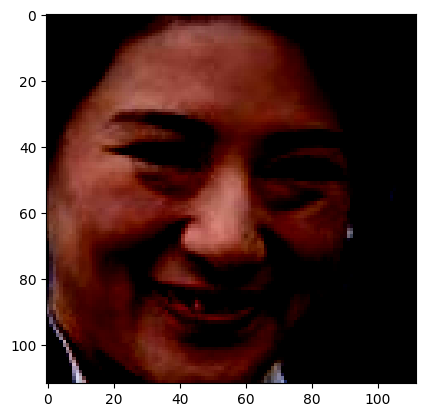

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


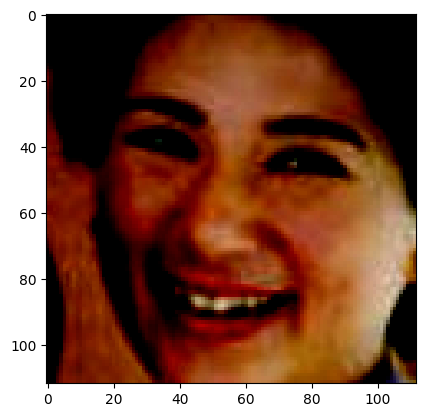

In [38]:
import matplotlib.pyplot as plt
import random 
ran = random.randint(0,100)
print(test_set[ran]["label"])
print(type(test_set[ran]["label"]))
for i in test_set[ran]["images"]:
    plt.imshow(i.permute(1,2,0))
    plt.show()


In [2]:
from model import get_model
data_dir = "/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/"
model = get_model(base_dir=data_dir)

load model weigth..


In [96]:
import torch
ids = len(test_set)
device = "cuda:1"
model = model.to(device)
model.eval()

TP = 0
FP = 0
TN = 0
FN = 0

sim_threshold = 0.2
with torch.no_grad():
    while sim_threshold <= 8.0:
        print(f"============== {sim_threshold} ================")
        print(f"idx\t| TP\t TN\t FN\t FP\t | TAR%   @ FAR%")
        for i in range(ids):
            images = test_set[i]["images"]
            label = test_set[i]["label"]

            # print()
            # make same_vec_list
            same_vec_list = []
            for img in images:
                img, label = img.to(device), label.to(device)
                img = img.unsqueeze(0)
                embed_vec = model(img)
                same_vec_list.append(embed_vec)

            # make diff_vec_list
            diff_vec_list = []
            for _ in range(5):
                randidx = random.randint(0,ids-1)
                while randidx == i:
                    randidx = random.randint(0,ids-1)
                n = random.randint(0,len(test_set[randidx]["images"])-1)
                img = test_set[randidx]["images"][n].unsqueeze(0).to(device)
                embed_vec = model(img)
                diff_vec_list.append(embed_vec)
            
            # same_vec_list의 0번쨰 vector를 등록된 vector로 가정한다.
            for j in range(1,len(same_vec_list)):
                sim_score = cos_sim(same_vec_list[0], same_vec_list[j])
                # print(sim_score)
                if sim_score > sim_threshold:
                    TP += 1
                else:
                    FN += 1     # positive이지만 negative라고 질못 판단함
            # print()
            for j in range(len(diff_vec_list)):
                sim_score = cos_sim(same_vec_list[0], diff_vec_list[j])
                # print(sim_score)
                if sim_score > sim_threshold:
                    FP += 1     # negative이지만 positive라고 잘못 판단함
                else:
                    TN += 1
            FAR = (FP/(FP+TN))*100
            TAR = (TP/(TP+FN))*100
            print(f"{i}\t| {TP}\t {TN}\t {FN}\t {FP}\t | {TAR}% @ {FAR}%")
        sim_threshold += 0.1
            # break


idx	| TP	 TN	 FN	 FP	 | TAR%   @ FAR%
0	| 2	 5	 0	 0	 | 100.0% @ 0.0%
1	| 4	 10	 0	 0	 | 100.0% @ 0.0%
2	| 7	 15	 0	 0	 | 100.0% @ 0.0%


In [ ]:
# FAR(False Acceptance Rate) = Fall-out = FP/(FP+TN)
# TAR(True Acceptance Rate) = recall = TP/(TP+FN)

In [67]:
print(TP)
print(TN)
print(FP)
print(FN)

2
3
0
0


In [68]:
FAR = (FP/(FP+TN))*100
print(FAR)
TAR = (TP/(TP+FN))*100
print(TAR)

0.0
100.0
